[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/02b-pasient_likhetsnettverk_iris_utvidet.ipynb)


Versjon 2025.12.03 - A. Lundervold

Lab 1: bruk `elmed219-2025` conda-miljøet


# Pasient-likhetsnettverk med utvidet IRIS-data

## Fra kontinuerlige målinger til mixed data – mot mer realistiske kliniske scenarioer

---

### 🎯 Læringsmål

Etter denne notebooken skal du kunne:

1. **Forstå utfordringen med mixed data** – kombinasjonen av kontinuerlige, kategoriske og ordinale variabler
2. **Generere realistiske syntetiske datasett** basert på kjente fordelinger
3. **Beregne Gower distance** og andre similaritetsmål for mixed data
4. **Sammenligne resultater** fra ulike similaritetsmål
5. **Reflektere over valg av variabler og vekting** i kliniske PSN-applikasjoner

---

### 🌸 Hvorfor utvide IRIS-datasettet?

I den forrige notebooken (`02-pasient_likhetsnettverk_iris.ipynb`) brukte vi det originale IRIS-datasettet med kun **kontinuerlige variabler** (fire blomstermålinger). 

Men i virkelige kliniske data har vi nesten alltid en **mix av variabeltyper**:

| Variabeltype | Eksempler (kliniske) | Eksempler (IRIS-utvidet) |
|--------------|---------------------|--------------------------|
| **Kontinuerlig** | Blodtrykk, alder, labverdier | Kronbladlengde, -bredde, etc. |
| **Kategorisk (nominal)** | Kjønn, blodtype, diagnose | Habitat, region, bladform |
| **Ordinal** | Smertenivå (1-10), sykdomsstadium | Helsetilstand, vekststadium |
| **Binær** | Røyker (ja/nei), diabetes (ja/nei) | Blomstrer (ja/nei), skadet (ja/nei) |

**Utfordringen:** Euklidsk avstand fungerer bare for kontinuerlige data. Hva gjør vi når vi har mixed data?


<details>
<summary>🌿 <b>Dypdykk: Biologien bak IRIS-artene</b> (klikk for å utvide)</summary>

### De tre IRIS-artene i datasettet

**Iris setosa** (Dverg-iris)
- **Habitat:** Våtmarker, myrer, arktiske områder
- **Geografisk utbredelse:** Alaska, Canada, Sibir, Nord-Europa
- **Særtrekk:** Lav vekst (15-30 cm), tolererer frost godt
- **Blomsterfarge:** Ofte blå-lilla med hvite og gule markeringer

**Iris versicolor** (Blåflagg)
- **Habitat:** Fuktige enger, våtmarker, elvekanter
- **Geografisk utbredelse:** Østlige Nord-Amerika
- **Særtrekk:** Middels høyde (30-60 cm), variabel i utseende
- **Blomsterfarge:** Blå-fiolett, kan variere betydelig

**Iris virginica** (Sør-blåflagg)
- **Habitat:** Våtmarker, sumper, kystnære områder
- **Geografisk utbredelse:** Sørøstlige USA
- **Særtrekk:** Høy vekst (60-90 cm), større blomster
- **Blomsterfarge:** Dyp blå-lilla

### Har IRIS-blomster kjønn?

**Nei** – Iris-blomster er **hermafroditter** (tvekjønnede). Hver blomst har både:
- **Støvbærere** (hannlige organer) som produserer pollen
- **Støvveien** (hunnlige organer) som mottar pollen

Dette er vanlig for mange blomsterplanter og kalles **perfekte blomster** i botanikken.

### Hvorfor simulerer vi da "kategoriske variabler"?

Selv om blomstene ikke har kjønn, har de mange andre kategoriske egenskaper:
- Habitattype (våtmark, eng, skog)
- Geografisk region
- Bladform og -farge
- Helsetilstand
- Vekststadium

I denne notebooken simulerer vi disse variablene for å lære teknikker som er direkte overførbare til pasientdata!

</details>


---
## Del 1: Forberedelser og datagenering


### Steg 1: Last inn nødvendige biblioteker


In [1]:
# Undertrykk advarsler
import warnings
warnings.filterwarnings('ignore')

# Numeriske beregninger og databehandling
import numpy as np
import pandas as pd

# Visualisering
import matplotlib.pyplot as plt
import seaborn as sns

# Nettverksanalyse
import networkx as nx

# Originaldata
from sklearn.datasets import load_iris

# For Gower distance
from scipy.spatial.distance import pdist, squareform

# For kategorisk håndtering
from sklearn.preprocessing import LabelEncoder

# Hjelpefunksjoner
from IPython.display import display, Markdown, HTML
from typing import Dict, List, Tuple, Optional

# Sett estetikk
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Alle biblioteker er lastet inn!")


✓ Alle biblioteker er lastet inn!


### Steg 2: Generer syntetisk utvidet IRIS-datasett

Vi lager et datasett med **n=600** blomster (200 per art) som inkluderer:
- **4 kontinuerlige variabler** (basert på originaldata)
- **3 kategoriske variabler** (habitat, region, bladform)
- **2 ordinale variabler** (helsetilstand, vekststadium)
- **2 binære variabler** (blomstrer, skadet)


<details>
<summary>🌿 <b>Dypdykk: Motivasjon for de nye variablene</b> (klikk for å utvide)</summary>

### De tre IRIS-artene

<img src="../assets/iris_species.png" width="700">

*De tre artene i IRIS-datasettet: Iris setosa, Iris versicolor og Iris virginica. Legg merke til de karakteristiske forskjellene i kronblad (petal) og begerblad (sepal). Kilde: [DAT158-kurset, HVL](https://github.com/HVL-ML/DAT158)*

---

### Hvorfor akkurat disse variablene?

De fire originale IRIS-variablene (sepal/petal lengde og bredde) er velprøvde mål fra [Fishers klassiske datasett fra 1936](https://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x). Men i en realistisk botanisk feltstudie ville forskere typisk registrere langt flere egenskaper. Her er den økologiske begrunnelsen for hver ny variabel:

---

### 📍 Kategoriske variabler

**Habitat (våtmark, eng, skog)**

De tre IRIS-artene har ulike habitatpreferanser som reflekterer deres evolusjonære tilpasninger:

| Art | Foretrukket habitat | Økologisk forklaring |
|-----|---------------------|----------------------|
| *I. setosa* | **Våtmark** (70%) | Arktisk/subarktisk art tilpasset myrlandskap og fuktige tundraområder |
| *I. versicolor* | **Eng/våtmark** (lik) | Generalist som trives i overgangssoner mellom våt og tørr mark |
| *I. virginica* | **Våtmark** (60%) | Sumpplante som vokser langs elvebredder og i kystmyrer i sørlige USA |

**Region (nord, sentral, sør)**

Geografisk utbredelse følger artenes naturlige range:

| Art | Dominerende region | Naturlig utbredelse |
|-----|-------------------|---------------------|
| *I. setosa* | **Nord** (80%) | Sirkumpolar: Alaska, Canada, Sibir, Nord-Skandinavia |
| *I. versicolor* | **Sentral** (60%) | Temperert Nord-Amerika: Great Lakes-regionen til New England |
| *I. virginica* | **Sør** (60%) | Subtropisk/temperert: Virginia til Florida, Gulf Coast |

**Bladform (smal, middels, bred)**

Bladmorfologi varierer med klimatilpasning:

- **Smale blader** → Reduserer vanntap, vanlig i kalde/tørre forhold (*I. setosa*)
- **Brede blader** → Maksimerer fotosyntese i varme, fuktige områder (*I. virginica*)
- **Middels** → Balansert tilpasning i tempererte soner (*I. versicolor*)

---

### 📊 Ordinale variabler

**Helsetilstand (1-5 skala)**

Denne variabelen simulerer en feltbotanikers vurdering av plantens generelle tilstand:

| Score | Beskrivelse | Typiske tegn |
|-------|-------------|--------------|
| 1 | Svært dårlig | Omfattende gulning, visning, synlig sykdom |
| 2 | Dårlig | Delvis gulning, redusert vekst |
| 3 | Middels | Noen svake tegn, men generelt akseptabel |
| 4 | God | Sunn vekst, grønne blader, normal størrelse |
| 5 | Utmerket | Optimal kondisjon, kraftig blomstring |

*I. setosa* har høyest gjennomsnittlig helse (4.0) fordi den er evolusjonært tilpasset tøffe forhold og dermed mer robust. *I. virginica* har lavest (3.2) fordi den vokser i våtmarker med mer sykdomspress (sopp, råte).

**Vekststadium (ung → moden → gammel)**

Iris-planter er flerårige og gjennomgår tydelige livsfaser:

| Stadium | Alder (typisk) | Kjennetegn |
|---------|----------------|------------|
| Ung | 1-2 år | Små rhizomer, få blader, sjelden blomstring |
| Moden | 3-7 år | Optimal størrelse, kraftig blomstring |
| Gammel | 8+ år | Store klynger, kan ha redusert vitalitet |

---

### ✅ Binære variabler

**Blomstrer (ja/nei)**

Ikke alle individer blomstrer hvert år – dette avhenger av:
- **Alder**: Unge planter blomstrer sjeldnere
- **Ressurser**: Næringsfattig jord → færre blomster
- **Sesong**: Innsamlingstidspunkt påvirker (simulert: tidlig sommer)

*I. setosa* har høyest blomstringsrate (60%) fordi kort vekstsesong i nord favoriserer rask reproduksjon.

**Skadet (ja/nei)**

Skader kan skyldes:
- **Herbivori**: Hjort, hare, insekter
- **Sykdom**: Sopputbrudd (spesielt i fuktige habitat)
- **Mekanisk**: Vind, tråkking, oversvømmelse

*I. setosa* har lavest skaderate (10%) pga. giftige alkaloider og isolerte habitater. *I. virginica* har høyest (25%) fordi våtmarkshabitat gir høyere sykdomspress.

---

### 🏥 Klinisk analogi

Disse variablene har direkte paralleller til pasientdata:

| IRIS-variabel | Klinisk analog | Variabeltype |
|---------------|----------------|--------------|
| sepal_length etc. | Blodprøver (HbA1c, kolesterol) | Kontinuerlig |
| habitat | Bosted (urban/rural/kyst) | Kategorisk |
| region | Geografisk helseregion | Kategorisk |
| bladform | Kroppstype/konstitusjon | Kategorisk |
| helse | Legenes kliniske vurdering | Ordinal |
| vekststadium | Aldersgruppe (barn/voksen/eldre) | Ordinal |
| blomstrer | Gravid (ja/nei) | Binær |
| skadet | Tidligere skade/sykdom (ja/nei) | Binær |

---

### 📚 Referanser og videre lesing

**Originaldatasettet:**
- Fisher, R.A. (1936). ["The use of multiple measurements in taxonomic problems"](https://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x). *Annals of Eugenics*, 7(2), 179-188.

**Botaniske ressurser om IRIS-artene:**
- [USDA Plants Database: *Iris setosa*](https://plants.usda.gov/home/plantProfile?symbol=IRSE)
- [USDA Plants Database: *Iris versicolor*](https://plants.usda.gov/home/plantProfile?symbol=IRVE2)
- [USDA Plants Database: *Iris virginica*](https://plants.usda.gov/home/plantProfile?symbol=IRVI)
- [Flora of North America: Iris](http://www.efloras.org/florataxon.aspx?flora_id=1&taxon_id=116630)

**Om habitater og økologi:**
- [Missouri Botanical Garden: Iris versicolor](https://www.missouribotanicalgarden.org/PlantFinder/PlantFinderDetails.aspx?taxonid=279555)
- [Lady Bird Johnson Wildflower Center: Native Iris species](https://www.wildflower.org/plants/search.php?search_field=iris&newsearch=true)

</details>


#### 🔬 Algoritmen for syntetisk datagenerering

For å lage et realistisk utvidet datasett bruker vi en **parametrisk simuleringsmetode** som bevarer de statistiske egenskapene til det originale IRIS-datasettet, samtidig som vi legger til nye variabler med biologisk plausible fordelinger.

**Metode:**

1. **Kontinuerlige variabler** – Genereres fra normalfordelinger $X \sim \mathcal{N}(\mu, \sigma)$ hvor $\mu$ og $\sigma$ er estimert fra originaldata for hver art:
   - Vi bruker de faktiske gjennomsnittene og standardavvikene fra Fishers 150 blomster
   - Dette sikrer at de syntetiske dataene har samme statistiske signatur som ekte data

2. **Kategoriske variabler** – Genereres fra multinomialfordelinger med artsspesifikke sannsynligheter:
   - Sannsynlighetene er basert på biologisk kunnskap om artenes økologi
   - Eksempel: *I. setosa* har 70% sannsynlighet for våtmark, 20% eng, 10% skog

3. **Ordinale variabler** – Kombinasjon av normalfordeling og diskretisering:
   - Helsetilstand: $\text{helse} = \text{round}(\text{clip}(\mathcal{N}(\mu_h, 0.8), 1, 5))$
   - Vekststadium: Multinomial med artsspesifikke sannsynligheter

4. **Binære variabler** – Genereres fra Bernoulli-fordelinger:
   - $\text{blomstrer} \sim \text{Bernoulli}(p_b)$ hvor $p_b$ varierer per art
   - $\text{skadet} \sim \text{Bernoulli}(p_d)$ hvor $p_d$ reflekterer sårbarhet

**Hvorfor denne tilnærmingen?**

| Fordel | Forklaring |
|--------|------------|
| **Reproduserbarhet** | `random_state` gir identiske resultater hver gang |
| **Skalerbarhet** | Vi kan generere vilkårlig mange eksemplarer (n=600 vs. original n=150) |
| **Realistiske korrelasjoner** | Artsspesifikke parametre bevarer naturlige sammenhenger |
| **Pedagogisk verdi** | Studentene kan eksperimentere med parametre og se effekten |

**Parametre i koden nedenfor:**

```
species_params = {
    'setosa': {
        'sepal_length': (μ=5.0, σ=0.35),  # Fra originaldata
        'habitat_probs': [0.7, 0.2, 0.1],  # Biologisk motivert
        'health_mean': 4.0,                # Robust art → høy helse
        ...
    },
    ...
}
```


In [2]:
def generate_extended_iris_data(n_per_species: int = 200, random_state: int = 42) -> pd.DataFrame:
    """
    Genererer et utvidet IRIS-datasett med mixed variabler.
    
    Parameters:
    -----------
    n_per_species : int
        Antall blomster per art (totalt blir n = 3 * n_per_species)
    random_state : int
        Seed for reproduserbarhet
    
    Returns:
    --------
    pd.DataFrame
        Utvidet datasett med kontinuerlige, kategoriske, ordinale og binære variabler
    """
    np.random.seed(random_state)
    
    # Last originaldata for å få realistiske parametre
    iris = load_iris()
    
    # Parametre for hver art (gjennomsnitt og standardavvik fra originaldata)
    species_params = {
        'setosa': {
            'sepal_length': (5.0, 0.35), 'sepal_width': (3.4, 0.38),
            'petal_length': (1.5, 0.17), 'petal_width': (0.2, 0.11),
            'habitat_probs': [0.7, 0.2, 0.1],      # våtmark, eng, skog
            'region_probs': [0.8, 0.15, 0.05],     # nord, sentral, sør
            'bladform_probs': [0.7, 0.25, 0.05],   # smal, middels, bred
            'health_mean': 4.0,                    # Robust art
            'growth_probs': [0.2, 0.5, 0.3],       # ung, moden, gammel
            'blooming_prob': 0.6,
            'damaged_prob': 0.1
        },
        'versicolor': {
            'sepal_length': (5.9, 0.52), 'sepal_width': (2.8, 0.31),
            'petal_length': (4.3, 0.47), 'petal_width': (1.3, 0.20),
            'habitat_probs': [0.4, 0.4, 0.2],
            'region_probs': [0.2, 0.6, 0.2],
            'bladform_probs': [0.2, 0.6, 0.2],
            'health_mean': 3.5,
            'growth_probs': [0.3, 0.4, 0.3],
            'blooming_prob': 0.5,
            'damaged_prob': 0.2
        },
        'virginica': {
            'sepal_length': (6.6, 0.64), 'sepal_width': (3.0, 0.32),
            'petal_length': (5.6, 0.55), 'petal_width': (2.0, 0.27),
            'habitat_probs': [0.6, 0.25, 0.15],
            'region_probs': [0.1, 0.3, 0.6],
            'bladform_probs': [0.1, 0.3, 0.6],
            'health_mean': 3.2,
            'growth_probs': [0.25, 0.45, 0.3],
            'blooming_prob': 0.55,
            'damaged_prob': 0.25
        }
    }
    
    data = []
    habitats = ['våtmark', 'eng', 'skog']
    regions = ['nord', 'sentral', 'sør']
    bladformer = ['smal', 'middels', 'bred']
    growth_stages = ['ung', 'moden', 'gammel']
    
    for species_name, params in species_params.items():
        for i in range(n_per_species):
            row = {
                'id': f"{species_name[:3]}_{i+1:03d}",
                'species': species_name,
                
                # Kontinuerlige variabler (normalfordelt rundt artsgjennomsnitt)
                'sepal_length': np.random.normal(*params['sepal_length']),
                'sepal_width': np.random.normal(*params['sepal_width']),
                'petal_length': np.random.normal(*params['petal_length']),
                'petal_width': np.random.normal(*params['petal_width']),
                
                # Kategoriske variabler (multinomial)
                'habitat': np.random.choice(habitats, p=params['habitat_probs']),
                'region': np.random.choice(regions, p=params['region_probs']),
                'bladform': np.random.choice(bladformer, p=params['bladform_probs']),
                
                # Ordinale variabler
                'helse': np.clip(np.random.normal(params['health_mean'], 0.8), 1, 5).round().astype(int),
                'vekststadium': np.random.choice(growth_stages, p=params['growth_probs']),
                
                # Binære variabler
                'blomstrer': np.random.random() < params['blooming_prob'],
                'skadet': np.random.random() < params['damaged_prob']
            }
            data.append(row)
    
    df = pd.DataFrame(data)
    
    # Konverter vekststadium til ordinal (numerisk for beregninger)
    growth_order = {'ung': 1, 'moden': 2, 'gammel': 3}
    df['vekststadium_ord'] = df['vekststadium'].map(growth_order)
    
    return df

# Generer datasettet
df_extended = generate_extended_iris_data(n_per_species=200)

print(f"✓ Datasett generert med {len(df_extended)} blomster")
print(f"\nVariabler ({len(df_extended.columns)} totalt):")
print(df_extended.dtypes)


✓ Datasett generert med 600 blomster

Variabler (14 totalt):
id                   object
species              object
sepal_length        float64
sepal_width         float64
petal_length        float64
petal_width         float64
habitat              object
region               object
bladform             object
helse                 int64
vekststadium         object
blomstrer              bool
skadet                 bool
vekststadium_ord      int64
dtype: object


### Steg 3: Utforsk det utvidede datasettet


In [3]:
# Vis de første radene
print("De første 5 radene av datasettet:")
display(df_extended.head())

# Oppsummering per art
print("\n" + "="*60)
print("OPPSUMMERING PER ART")
print("="*60)

for species_name in ['setosa', 'versicolor', 'virginica']:
    subset = df_extended[df_extended['species'] == species_name]
    print(f"\n{'='*20} {species_name.upper()} {'='*20}")
    print(f"Antall: {len(subset)}")
    print(f"\nKontinuerlige (gjennomsnitt ± std):")
    for col in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
        print(f"  {col}: {subset[col].mean():.2f} ± {subset[col].std():.2f}")
    print(f"\nKategoriske (frekvenser):")
    print(f"  Habitat: {dict(subset['habitat'].value_counts())}")
    print(f"  Region: {dict(subset['region'].value_counts())}")
    print(f"  Bladform: {dict(subset['bladform'].value_counts())}")
    print(f"\nOrdinale:")
    print(f"  Helsetilstand (1-5): {subset['helse'].mean():.2f} ± {subset['helse'].std():.2f}")
    print(f"  Vekststadium: {dict(subset['vekststadium'].value_counts())}")
    print(f"\nBinære:")
    print(f"  Blomstrer: {subset['blomstrer'].sum()} ({subset['blomstrer'].mean()*100:.1f}%)")
    print(f"  Skadet: {subset['skadet'].sum()} ({subset['skadet'].mean()*100:.1f}%)")


De første 5 radene av datasettet:


,id,species,sepal_length,sepal_width,petal_length,petal_width,habitat,region,bladform,helse,vekststadium,blomstrer,skadet,vekststadium_ord
0,set_001,setosa,5.173850,3.347460,1.610107,0.367533,våtmark,nord,smal,4,gammel,True,False,3
1,set_002,setosa,5.353680,3.221600,1.592235,0.149024,våtmark,nord,smal,4,moden,False,False,2
2,set_003,setosa,4.682192,2.863325,1.749160,0.175165,våtmark,nord,smal,4,ung,True,False,1
3,set_004,setosa,4.819598,3.171757,1.450412,0.133812,våtmark,nord,smal,5,gammel,True,False,3
4,set_005,setosa,5.073102,2.655325,1.274208,0.221655,skog,nord,middels,4,gammel,True,False,3



OPPSUMMERING PER ART

==================== SETOSA ====================
Antall: 200

Kontinuerlige (gjennomsnitt ± std):
  sepal_length: 5.00 ± 0.31
  sepal_width: 3.40 ± 0.42
  petal_length: 1.49 ± 0.18
  petal_width: 0.20 ± 0.10

Kategoriske (frekvenser):
  Habitat: {np.str_('våtmark'): np.int64(140), np.str_('eng'): np.int64(40), np.str_('skog'): np.int64(20)}
  Region: {np.str_('nord'): np.int64(155), np.str_('sentral'): np.int64(37), np.str_('sør'): np.int64(8)}
  Bladform: {np.str_('smal'): np.int64(137), np.str_('middels'): np.int64(48), np.str_('bred'): np.int64(15)}

Ordinale:
  Helsetilstand (1-5): 4.03 ± 0.77
  Vekststadium: {np.str_('moden'): np.int64(98), np.str_('gammel'): np.int64(65), np.str_('ung'): np.int64(37)}

Binære:
  Blomstrer: 116 (58.0%)
  Skadet: 19 (9.5%)

==================== VERSICOLOR ====================
Antall: 200

Kontinuerlige (gjennomsnitt ± std):
  sepal_length: 5.92 ± 0.55
  sepal_width: 2.79 ± 0.31
  petal_length: 4.34 ± 0.46
  petal_width: 1.31 

### ❓ Spørsmål til refleksjon 1

Før vi går videre, tenk over:

1. **Hvorfor varierer habitatfordelingen mellom artene?** Hva forteller dette om artenes økologi?

2. **Hva betyr det at setosa har høyere gjennomsnittlig helsetilstand?** Er dette realistisk biologisk sett?

3. **Hvilke variabler tror du vil bidra mest til å skille artene?** De kontinuerlige eller de kategoriske?

4. **I en klinisk setting:** Hvis dette var pasientdata, hvilke variabler ville tilsvare:
   - Labverdier?
   - Diagnose?
   - Livsstilsfaktorer?


---
## Del 2: Similaritetsmål for mixed data

### Utfordringen med heterogene variabler

Når vi har **mixed data** (ulike variabeltyper), kan vi ikke bruke ren Euklidsk avstand. Hvorfor?

- **Kategoriske variabler** har ingen naturlig ordning eller avstand
- **Binære variabler** er enten "like" eller "ulike"
- **Ordinale variabler** har ordning, men ikke nødvendigvis like intervaller

Vi trenger derfor **spesialiserte mål** som håndterer hver type.


<details>
<summary>🔬 <b>Dypdykk: Matematikken bak Gower Distance</b> (klikk for å utvide)</summary>

### Gower Distance – den universelle løsningen

**Gower distance** (Gower, 1971) er designet spesifikt for mixed data. For to observasjoner $i$ og $j$:

$$d_{ij}^{Gower} = \frac{\sum_{k=1}^{p} w_k \cdot d_{ij}^{(k)}}{\sum_{k=1}^{p} w_k}$$

hvor $d_{ij}^{(k)}$ er bidraget fra variabel $k$, og $w_k$ er vekten til variabel $k$.

### Beregning per variabeltype

| Variabeltype | Formel for $d_{ij}^{(k)}$ | Forklaring |
|--------------|--------------------------|------------|
| **Kontinuerlig** | $\frac{|x_{ik} - x_{jk}|}{R_k}$ | Normalisert absolutt forskjell, $R_k$ = range |
| **Kategorisk** | $\begin{cases} 0 & \text{hvis } x_{ik} = x_{jk} \\ 1 & \text{hvis } x_{ik} \neq x_{jk} \end{cases}$ | 0 hvis like, 1 hvis ulike |
| **Binær** | Samme som kategorisk | Spesialtilfelle |
| **Ordinal** | $\frac{|r_{ik} - r_{jk}|}{R_k - 1}$ | Normalisert rangforskjell |

### Eksempelberegning

La oss si vi sammenligner to blomster med 3 variabler:

| Variabel | Blomst A | Blomst B | Type | Range/Nivåer |
|----------|----------|----------|------|--------------|
| sepal_length | 5.0 | 6.0 | Kontinuerlig | [4.0, 8.0] |
| habitat | våtmark | eng | Kategorisk | 3 kategorier |
| helse | 4 | 2 | Ordinal | [1, 5] |

**Beregning:**

1. **sepal_length (kontinuerlig):** 
   $$d^{(1)} = \frac{|5.0 - 6.0|}{8.0 - 4.0} = \frac{1.0}{4.0} = 0.25$$

2. **habitat (kategorisk):**
   $$d^{(2)} = 1 \quad \text{(ulike verdier)}$$

3. **helse (ordinal):**
   $$d^{(3)} = \frac{|4 - 2|}{5 - 1} = \frac{2}{4} = 0.5$$

**Gower distance (med like vekter):**
$$d_{AB}^{Gower} = \frac{0.25 + 1.0 + 0.5}{3} = \frac{1.75}{3} \approx 0.58$$

**Gower similarity:**
$$s_{AB}^{Gower} = 1 - d_{AB}^{Gower} = 1 - 0.58 = 0.42$$

### Egenskaper

- ✅ Håndterer alle variabeltyper i én formel
- ✅ Alltid i intervallet [0, 1]
- ✅ Tillater vekting av variabler
- ✅ Robust mot manglende verdier
- ⚠️ Forutsetter at alle variabler er like viktige (med mindre man vekter)

### Alternative mål

| Mål | Beste for | Formel |
|-----|-----------|--------|
| **Jaccard** | Binære data | $\frac{|A \cap B|}{|A \cup B|}$ |
| **Hamming** | Kategoriske | $\frac{\text{antall ulike}}{p}$ |
| **Manhattan** | Kontinuerlige | $\sum_k |x_{ik} - x_{jk}|$ |
| **Cosine** | Høydimensjonale | $\frac{A \cdot B}{||A|| \cdot ||B||}$ |

</details>


### Steg 4: Implementer Gower Distance


In [4]:
def compute_gower_distance(df: pd.DataFrame, 
                            continuous_cols: List[str],
                            categorical_cols: List[str],
                            ordinal_cols: List[str],
                            binary_cols: List[str],
                            weights: Optional[Dict[str, float]] = None) -> np.ndarray:
    """
    Beregner Gower distance-matrise for mixed data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input data
    continuous_cols : List[str]
        Navn på kontinuerlige kolonner
    categorical_cols : List[str]
        Navn på kategoriske kolonner
    ordinal_cols : List[str]
        Navn på ordinale kolonner (må være numerisk kodet)
    binary_cols : List[str]
        Navn på binære kolonner
    weights : Optional[Dict[str, float]]
        Vekter per kolonne (default: like vekter)
    
    Returns:
    --------
    np.ndarray
        n x n distance-matrise
    """
    n = len(df)
    all_cols = continuous_cols + categorical_cols + ordinal_cols + binary_cols
    
    # Sett like vekter hvis ikke spesifisert
    if weights is None:
        weights = {col: 1.0 for col in all_cols}
    
    # Normaliser vekter
    total_weight = sum(weights.values())
    weights = {k: v/total_weight for k, v in weights.items()}
    
    # Beregn ranges for kontinuerlige og ordinale
    ranges = {}
    for col in continuous_cols:
        ranges[col] = df[col].max() - df[col].min()
    for col in ordinal_cols:
        ranges[col] = df[col].max() - df[col].min()
    
    # Initialiser distance-matrise
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            total_dist = 0.0
            total_w = 0.0
            
            # Kontinuerlige variabler
            for col in continuous_cols:
                if ranges[col] > 0:
                    d = abs(df.iloc[i][col] - df.iloc[j][col]) / ranges[col]
                else:
                    d = 0
                total_dist += weights[col] * d
                total_w += weights[col]
            
            # Kategoriske variabler
            for col in categorical_cols:
                d = 0 if df.iloc[i][col] == df.iloc[j][col] else 1
                total_dist += weights[col] * d
                total_w += weights[col]
            
            # Ordinale variabler
            for col in ordinal_cols:
                if ranges[col] > 0:
                    d = abs(df.iloc[i][col] - df.iloc[j][col]) / ranges[col]
                else:
                    d = 0
                total_dist += weights[col] * d
                total_w += weights[col]
            
            # Binære variabler
            for col in binary_cols:
                d = 0 if df.iloc[i][col] == df.iloc[j][col] else 1
                total_dist += weights[col] * d
                total_w += weights[col]
            
            # Normaliser
            gower_dist = total_dist / total_w if total_w > 0 else 0
            dist_matrix[i, j] = gower_dist
            dist_matrix[j, i] = gower_dist
    
    return dist_matrix

# Definer kolonnetyper
continuous_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
categorical_cols = ['habitat', 'region', 'bladform']
ordinal_cols = ['helse', 'vekststadium_ord']
binary_cols = ['blomstrer', 'skadet']

print("Kolonnetyper definert:")
print(f"  Kontinuerlige: {continuous_cols}")
print(f"  Kategoriske: {categorical_cols}")
print(f"  Ordinale: {ordinal_cols}")
print(f"  Binære: {binary_cols}")


Kolonnetyper definert:
  Kontinuerlige: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
  Kategoriske: ['habitat', 'region', 'bladform']
  Ordinale: ['helse', 'vekststadium_ord']
  Binære: ['blomstrer', 'skadet']


### Steg 5: Beregn og sammenlign distance-matriser

Vi sammenligner tre tilnærminger:
1. **Kun kontinuerlige** (Euklidsk avstand, som i forrige notebook)
2. **Full Gower** (alle variabler, like vekter)
3. **Vektet Gower** (høyere vekt på kontinuerlige)


In [5]:
%%time
print("Beregner distance-matriser... (dette kan ta litt tid for n=600)")

# 1. Kun kontinuerlige (normalisert Euklidsk)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_continuous = scaler.fit_transform(df_extended[continuous_cols])

# Euklidsk avstand på normaliserte data
dist_euclidean = np.zeros((len(df_extended), len(df_extended)))
for i in range(len(df_extended)):
    for j in range(i+1, len(df_extended)):
        d = np.linalg.norm(X_continuous[i] - X_continuous[j])
        # Normaliser til [0,1] ved å dele på maks mulig avstand
        dist_euclidean[i, j] = d / np.sqrt(len(continuous_cols))
        dist_euclidean[j, i] = dist_euclidean[i, j]

print("✓ Euklidsk (kun kontinuerlige) beregnet")

# 2. Full Gower (like vekter)
dist_gower_equal = compute_gower_distance(
    df_extended, 
    continuous_cols, 
    categorical_cols, 
    ordinal_cols, 
    binary_cols
)
print("✓ Gower (like vekter) beregnet")

# 3. Vektet Gower (kontinuerlige vektes høyere)
custom_weights = {
    # Kontinuerlige: vekt 2.0 hver
    'sepal_length': 2.0, 'sepal_width': 2.0, 
    'petal_length': 2.0, 'petal_width': 2.0,
    # Kategoriske: vekt 1.0 hver
    'habitat': 1.0, 'region': 1.0, 'bladform': 1.0,
    # Ordinale: vekt 1.0 hver
    'helse': 1.0, 'vekststadium_ord': 1.0,
    # Binære: vekt 0.5 hver
    'blomstrer': 0.5, 'skadet': 0.5
}

dist_gower_weighted = compute_gower_distance(
    df_extended, 
    continuous_cols, 
    categorical_cols, 
    ordinal_cols, 
    binary_cols,
    weights=custom_weights
)
print("✓ Gower (vektet) beregnet")

# Konverter til similarity
sim_euclidean = 1 - dist_euclidean
sim_gower_equal = 1 - dist_gower_equal
sim_gower_weighted = 1 - dist_gower_weighted

print("\n✓ Alle distance-matriser beregnet og konvertert til similarity!")


Beregner distance-matriser... (dette kan ta litt tid for n=600)
✓ Euklidsk (kun kontinuerlige) beregnet
✓ Gower (like vekter) beregnet
✓ Gower (vektet) beregnet

✓ Alle distance-matriser beregnet og konvertert til similarity!
CPU times: user 1min 45s, sys: 400 ms, total: 1min 45s
Wall time: 1min 45s


### Steg 6: Visualiser similarity-matrisene


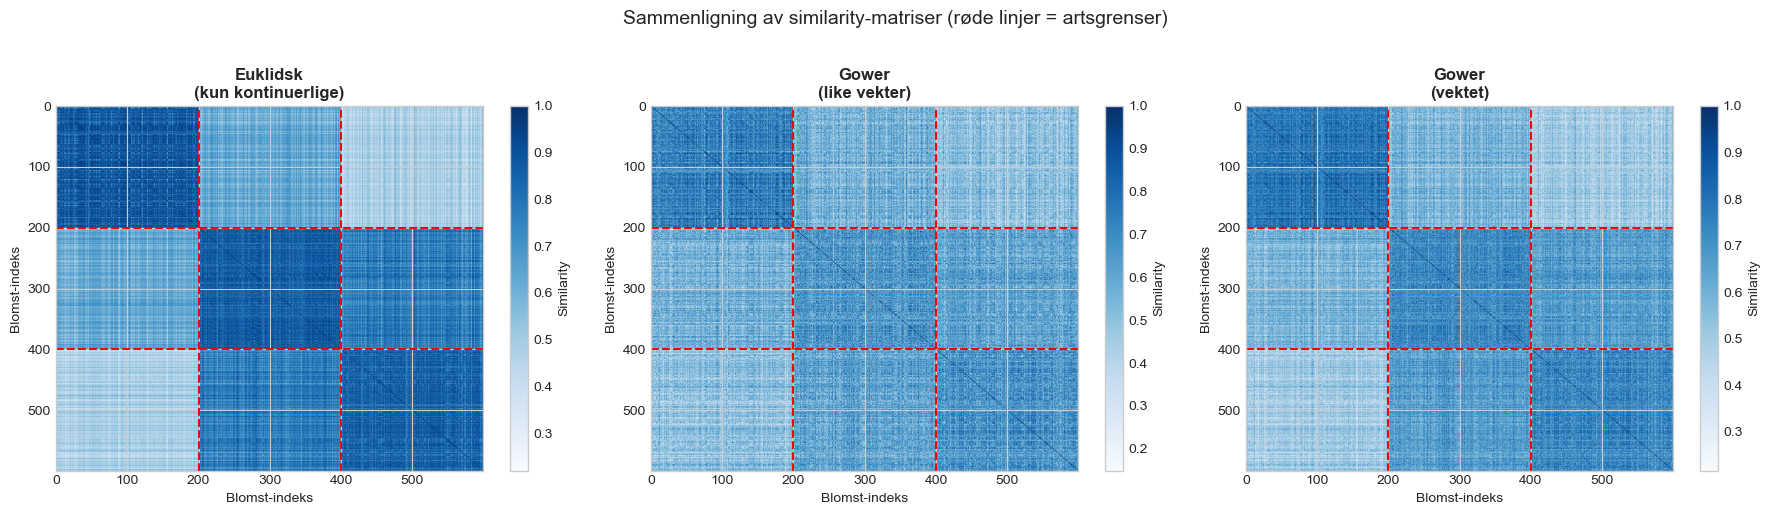


STATISTIKK FOR SIMILARITY-MATRISENE

Euklidsk:
  Gjennomsnitt: 0.700
  Std: 0.160
  Min: 0.220
  Max: 0.995

Gower (like):
  Gjennomsnitt: 0.599
  Std: 0.129
  Min: 0.149
  Max: 0.995

Gower (vektet):
  Gjennomsnitt: 0.637
  Std: 0.125
  Min: 0.217
  Max: 0.992


In [6]:
# Visualiser de tre similarity-matrisene
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

matrices = [
    (sim_euclidean, "Euklidsk\n(kun kontinuerlige)"),
    (sim_gower_equal, "Gower\n(like vekter)"),
    (sim_gower_weighted, "Gower\n(vektet)")
]

for ax, (matrix, title) in zip(axes, matrices):
    im = ax.imshow(matrix, cmap='Blues', aspect='auto')
    
    # Legg til artsgrenser
    for boundary in [200, 400]:
        ax.axhline(y=boundary, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(x=boundary, color='red', linestyle='--', linewidth=1.5)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Blomst-indeks')
    ax.set_ylabel('Blomst-indeks')
    plt.colorbar(im, ax=ax, label='Similarity')

plt.suptitle('Sammenligning av similarity-matriser (røde linjer = artsgrenser)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Beregn statistikk
print("\n" + "="*70)
print("STATISTIKK FOR SIMILARITY-MATRISENE")
print("="*70)

for name, matrix in [("Euklidsk", sim_euclidean), 
                      ("Gower (like)", sim_gower_equal), 
                      ("Gower (vektet)", sim_gower_weighted)]:
    # Ekskluder diagonalen
    upper_tri = matrix[np.triu_indices(len(matrix), k=1)]
    print(f"\n{name}:")
    print(f"  Gjennomsnitt: {upper_tri.mean():.3f}")
    print(f"  Std: {upper_tri.std():.3f}")
    print(f"  Min: {upper_tri.min():.3f}")
    print(f"  Max: {upper_tri.max():.3f}")


### ❓ Spørsmål til refleksjon 2

Se på de tre similarity-matrisene og svar:

1. **Hvilken matrise viser tydeligst separasjon mellom artene?** Hvorfor tror du det er slik?

2. **Hva skjer med similarity-verdiene når vi legger til kategoriske variabler?** Blir de høyere eller lavere i gjennomsnitt?

3. **Hvordan påvirker vektingen resultatet?** Sammenlign "Gower (like)" med "Gower (vektet)".

4. **Klinisk relevans:** Hvis du skulle bygge et PSN for diabetespasienter med både kontinuerlige (blodtrykk, HbA1c) og kategoriske (medisinering, livsstil) variabler – hvordan ville du vekte dem?


---
## Del 3: Bygg og sammenlign nettverk

Nå bygger vi nettverk fra de tre similarity-matrisene og sammenligner resultatene.


In [7]:
def build_network_from_similarity(sim_matrix: np.ndarray, 
                                   df: pd.DataFrame,
                                   threshold: float = 0.0) -> nx.Graph:
    """
    Bygg et NetworkX-nettverk fra en similarity-matrise.
    
    Parameters:
    -----------
    sim_matrix : np.ndarray
        n x n similarity-matrise
    df : pd.DataFrame
        DataFrame med node-attributter (må ha 'species' kolonne)
    threshold : float
        Minimum similarity for å inkludere en kant (0 = alle kanter)
    
    Returns:
    --------
    nx.Graph
        Vektet, urettet graf
    """
    G = nx.Graph()
    n = len(df)
    
    # Legg til noder med attributter
    for i in range(n):
        G.add_node(i, 
                   species=df.iloc[i]['species'],
                   habitat=df.iloc[i]['habitat'],
                   region=df.iloc[i]['region'])
    
    # Legg til kanter
    for i in range(n):
        for j in range(i+1, n):
            if sim_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=sim_matrix[i, j])
    
    return G

# Bygg tre nettverk (komplett, threshold=0)
G_euclidean = build_network_from_similarity(sim_euclidean, df_extended)
G_gower_equal = build_network_from_similarity(sim_gower_equal, df_extended)
G_gower_weighted = build_network_from_similarity(sim_gower_weighted, df_extended)

print("Nettverk bygget:")
for name, G in [("Euklidsk", G_euclidean), 
                ("Gower (like)", G_gower_equal), 
                ("Gower (vektet)", G_gower_weighted)]:
    print(f"  {name}: {G.number_of_nodes()} noder, {G.number_of_edges()} kanter")


Nettverk bygget:
  Euklidsk: 600 noder, 179700 kanter
  Gower (like): 600 noder, 179700 kanter
  Gower (vektet): 600 noder, 179700 kanter


### Steg 7: Community detection og sammenligning


In [8]:
import community.community_louvain as community_louvain
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def analyze_community_detection(G: nx.Graph, df: pd.DataFrame, name: str) -> dict:
    """
    Utfør community detection og sammenlign med faktiske arter.
    """
    # Utfør Louvain community detection
    communities = community_louvain.best_partition(G)
    
    # Hent faktiske art-labels
    true_labels = [df.iloc[i]['species'] for i in range(len(df))]
    label_encoder = LabelEncoder()
    true_numeric = label_encoder.fit_transform(true_labels)
    
    # Hent predikerte communities
    pred_labels = [communities[i] for i in range(len(df))]
    
    # Beregn metrikker
    n_communities = len(set(communities.values()))
    modularity = community_louvain.modularity(communities, G)
    ari = adjusted_rand_score(true_numeric, pred_labels)
    nmi = normalized_mutual_info_score(true_numeric, pred_labels)
    
    return {
        'name': name,
        'n_communities': n_communities,
        'modularity': modularity,
        'ari': ari,  # Adjusted Rand Index
        'nmi': nmi,  # Normalized Mutual Information
        'communities': communities
    }

# Analyser alle tre nettverk
results = []
for name, G in [("Euklidsk", G_euclidean), 
                ("Gower (like)", G_gower_equal), 
                ("Gower (vektet)", G_gower_weighted)]:
    result = analyze_community_detection(G, df_extended, name)
    results.append(result)

# Vis resultater i tabell
print("="*70)
print("COMMUNITY DETECTION RESULTATER")
print("="*70)
print(f"\n{'Metode':<20} {'# Comm.':<10} {'Modularitet':<12} {'ARI':<10} {'NMI':<10}")
print("-"*62)
for r in results:
    print(f"{r['name']:<20} {r['n_communities']:<10} {r['modularity']:<12.3f} {r['ari']:<10.3f} {r['nmi']:<10.3f}")

print("\n📖 Forklaring:")
print("  • # Comm. = Antall communities funnet")
print("  • Modularitet = Kvalitet på community-strukturen (høyere = bedre)")
print("  • ARI = Adjusted Rand Index (1 = perfekt match med arter)")
print("  • NMI = Normalized Mutual Information (1 = perfekt match med arter)")


COMMUNITY DETECTION RESULTATER

Metode               # Comm.    Modularitet  ARI        NMI       
--------------------------------------------------------------
Euklidsk             2          0.080        0.561      0.699     
Gower (like)         3          0.056        0.484      0.538     
Gower (vektet)       2          0.063        0.554      0.681     

📖 Forklaring:
  • # Comm. = Antall communities funnet
  • Modularitet = Kvalitet på community-strukturen (høyere = bedre)
  • ARI = Adjusted Rand Index (1 = perfekt match med arter)
  • NMI = Normalized Mutual Information (1 = perfekt match med arter)


<details>
<summary>🔬 <b>Dypdykk: Evalueringsmetrikker for klyngeanalyse</b> (klikk for å utvide)</summary>

### Adjusted Rand Index (ARI)

ARI måler likheten mellom to klyngepartisjoner, justert for tilfeldige tilfeller:

$$ARI = \frac{RI - E[RI]}{\max(RI) - E[RI]}$$

- **ARI = 1**: Perfekt match
- **ARI = 0**: Tilfeldig match
- **ARI < 0**: Dårligere enn tilfeldig

### Normalized Mutual Information (NMI)

NMI måler informasjonsteoretisk likhet mellom partisjoner:

$$NMI = \frac{2 \cdot I(U;V)}{H(U) + H(V)}$$

hvor:
- $I(U;V)$ = gjensidig informasjon mellom klyngene
- $H(U), H(V)$ = entropi for hver partisjon

- **NMI = 1**: Perfekt match
- **NMI = 0**: Ingen gjensidig informasjon

### Modularitet

Modularitet måler hvor godt et nettverk er delt inn i communities:

$$Q = \frac{1}{2m}\sum_{ij} [A_{ij} - \frac{k_i k_j}{2m}]\delta(c_i, c_j)$$

- **Q > 0.3**: Signifikant community-struktur
- **Q > 0.7**: Sterk community-struktur

### Hvilken metrikk velge?

| Situasjon | Anbefalt metrikk |
|-----------|------------------|
| Sammenlign med kjente grupper | ARI, NMI |
| Vurder nettverksstruktur | Modularitet |
| Ubalanserte klyngestørrelser | NMI (mer robust) |
| Alle har samme vekt | ARI |

</details>


### Steg 8: Visualiser nettverkene

Vi bruker en terskelbasert tilnærming for å redusere visuelt rot (kun viser kanter med høy similarity).


In [9]:
# Bygg terskelbaserte nettverk for visualisering (threshold = 0.7)
threshold = 0.7

G_euc_thresh = build_network_from_similarity(sim_euclidean, df_extended, threshold)
G_gow_eq_thresh = build_network_from_similarity(sim_gower_equal, df_extended, threshold)
G_gow_wt_thresh = build_network_from_similarity(sim_gower_weighted, df_extended, threshold)

print(f"Nettverk med terskel {threshold}:")
for name, G in [("Euklidsk", G_euc_thresh), 
                ("Gower (like)", G_gow_eq_thresh), 
                ("Gower (vektet)", G_gow_wt_thresh)]:
    print(f"  {name}: {G.number_of_edges()} kanter")


Nettverk med terskel 0.7:
  Euklidsk: 96077 kanter
  Gower (like): 40136 kanter
  Gower (vektet): 59241 kanter


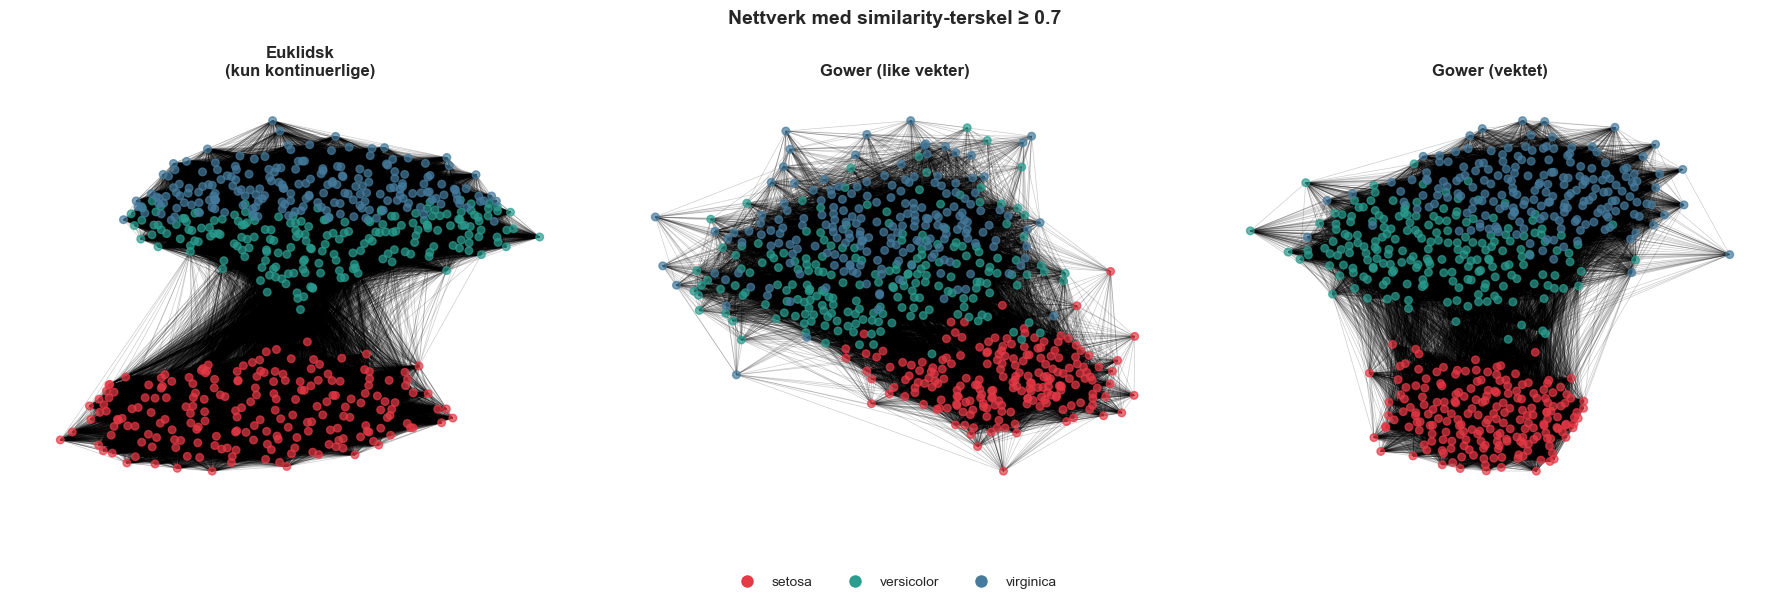

In [10]:
# Visualiser de tre nettverkene
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Farger for arter
color_dict = {
    'setosa': '#E63946',
    'versicolor': '#2A9D8F',
    'virginica': '#457B9D'
}

networks = [
    (G_euc_thresh, "Euklidsk\n(kun kontinuerlige)", results[0]['communities']),
    (G_gow_eq_thresh, "Gower (like vekter)", results[1]['communities']),
    (G_gow_wt_thresh, "Gower (vektet)", results[2]['communities'])
]

for ax, (G, title, communities) in zip(axes, networks):
    if G.number_of_edges() == 0:
        ax.text(0.5, 0.5, "Ingen kanter\n(terskel for høy)", 
                ha='center', va='center', fontsize=12)
        ax.set_title(title)
        ax.axis('off')
        continue
    
    # Farger basert på art
    node_colors = [color_dict[G.nodes[node]['species']] for node in G.nodes()]
    
    # Layout
    pos = nx.spring_layout(G, k=2/np.sqrt(len(G.nodes())), seed=42, iterations=50)
    
    # Kantvekter
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Tegn
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                           node_size=30, alpha=0.7, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=ax)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

# Legg til legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=color, label=species_name, markersize=10)
    for species_name, color in color_dict.items()
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)

plt.suptitle(f'Nettverk med similarity-terskel ≥ {threshold}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


### ❓ Spørsmål til refleksjon 3

1. **Hvordan påvirker terskelvalget nettverksstrukturen?** Prøv å endre `threshold` til 0.5 eller 0.8 – hva skjer?

2. **Hvilken metode gir best separasjon av artene visuelt?** Stemmer dette med ARI/NMI-verdiene?

3. **Hva betyr det at Gower (like) har lavere ARI enn Euklidsk?** Er dette alltid uønsket?

4. **Praktisk vurdering:** Hvis de kategoriske variablene (habitat, region) faktisk inneholder viktig klinisk informasjon – bør vi vekte dem høyere eller lavere?


---
## Del 4: Analyse av innad-art vs. mellom-art similarity

La oss undersøke hvordan de ulike metodene påvirker separasjonen mellom artene.


In [11]:
def analyze_within_between_similarity(sim_matrix: np.ndarray, 
                                       df: pd.DataFrame) -> dict:
    """
    Beregn gjennomsnittlig similarity innad og mellom arter.
    """
    n = len(df)
    within = {s: [] for s in ['setosa', 'versicolor', 'virginica']}
    between = []
    
    for i in range(n):
        for j in range(i+1, n):
            s_i = df.iloc[i]['species']
            s_j = df.iloc[j]['species']
            sim = sim_matrix[i, j]
            
            if s_i == s_j:
                within[s_i].append(sim)
            else:
                between.append(sim)
    
    return {
        'within': {s: np.mean(v) for s, v in within.items()},
        'between': np.mean(between),
        'within_all': np.mean([np.mean(v) for v in within.values()]),
        'ratio': np.mean([np.mean(v) for v in within.values()]) / np.mean(between)
    }

# Analyser alle tre
print("="*70)
print("INNAD-ART VS. MELLOM-ART SIMILARITY")
print("="*70)

for name, sim_mat in [("Euklidsk", sim_euclidean), 
                       ("Gower (like)", sim_gower_equal), 
                       ("Gower (vektet)", sim_gower_weighted)]:
    analysis = analyze_within_between_similarity(sim_mat, df_extended)
    
    print(f"\n{name}:")
    print(f"  Innad-art similarity:")
    for species, mean_sim in analysis['within'].items():
        print(f"    {species}: {mean_sim:.3f}")
    print(f"  Mellom-art similarity: {analysis['between']:.3f}")
    print(f"  Separasjonsratio: {analysis['ratio']:.2f}x")


INNAD-ART VS. MELLOM-ART SIMILARITY

Euklidsk:
  Innad-art similarity:
    setosa: 0.872
    versicolor: 0.857
    virginica: 0.842
  Mellom-art similarity: 0.622
  Separasjonsratio: 1.38x

Gower (like):
  Innad-art similarity:
    setosa: 0.735
    versicolor: 0.657
    virginica: 0.668
  Mellom-art similarity: 0.555
  Separasjonsratio: 1.24x

Gower (vektet):
  Innad-art similarity:
    setosa: 0.789
    versicolor: 0.727
    virginica: 0.733
  Mellom-art similarity: 0.581
  Separasjonsratio: 1.29x


---
## 📚 Oppsummering

### Hva har vi lært?

| Konsept | Beskrivelse |
|---------|-------------|
| **Mixed data** | Data med ulike variabeltyper krever spesialiserte similaritetsmål |
| **Gower distance** | Universelt mål som håndterer kontinuerlige, kategoriske, ordinale og binære variabler |
| **Vekting** | Vekter kan justeres basert på domenekunskap – ikke alle variabler er like viktige |
| **Evaluering** | ARI og NMI måler hvor godt detekterte communities matcher kjente grupper |
| **Trade-offs** | Å legge til variabler kan øke eller redusere separasjon avhengig av deres informasjonsinnhold |

### Hovedfunn fra dette eksperimentet

1. **Euklidsk (kun kontinuerlige)** gir ofte bedre artseparasjon fordi de fire blomstermålingene er svært informative
2. **Gower med like vekter** kan "utvanne" signalet fra de kontinuerlige variablene
3. **Vektet Gower** er en god mellomting – inkluderer ekstra informasjon men prioriterer de mest informative variablene

### Overføring til kliniske data

I kliniske PSN-applikasjoner:
- **Tenk nøye gjennom vekting** – labverdier kan være viktigere enn selvrapporterte data
- **Valider mot kjente grupper** – bruk ARI/NMI hvis du har diagnosegrupper
- **Eksperimenter med terskel** – ikke alle forbindelser er like relevante


---
## 💡 Øvelser

### Øvelse 1: Eksperimenter med vekting
Modifiser `custom_weights` for å:
a) Gi høyere vekt til habitat og region
b) Gi null vekt til binære variabler
c) Bare bruke kategoriske variabler

Hvordan påvirker dette ARI og NMI?

### Øvelse 2: Terskelanalyse
Lag en graf som viser hvordan ARI endrer seg som funksjon av similarity-terskel (0.3, 0.5, 0.7, 0.9).

### Øvelse 3: Alternativt similaritetsmål
Implementer **Jaccard similarity** for de kategoriske variablene og sammenlign med Gower.

### Øvelse 4: Klinisk design
Design et syntetisk pasientdatasett med:
- Kontinuerlige: HbA1c, blodtrykk, BMI
- Kategoriske: Medisintype, livsstil
- Ordinale: Smertenivå, funksjonsnivå
- Binær: Røyker, diabetes

Generer data for 3 pasientgrupper og bygg et PSN.


<details>
<summary>💡 <b>Hint til øvelsene</b> (klikk for å utvide)</summary>

### Hint til Øvelse 1
```python
# a) Høyere vekt på habitat og region
weights_a = {
    'sepal_length': 1.0, 'sepal_width': 1.0, 
    'petal_length': 1.0, 'petal_width': 1.0,
    'habitat': 3.0, 'region': 3.0, 'bladform': 1.0,  # ← Økt
    'helse': 1.0, 'vekststadium_ord': 1.0,
    'blomstrer': 0.5, 'skadet': 0.5
}
```

### Hint til Øvelse 2
```python
thresholds = [0.3, 0.5, 0.7, 0.9]
ari_scores = []

for thresh in thresholds:
    G_temp = build_network_from_similarity(sim_gower_weighted, df_extended, thresh)
    # ... community detection og ARI-beregning
    ari_scores.append(ari)

plt.plot(thresholds, ari_scores)
```

### Hint til Øvelse 3
Jaccard for kategoriske sett:
$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

For kategoriske variabler: tell antall variabler som er like, del på totalt antall.

</details>


<details>
<summary>✅ <b>Løsningsforslag til Øvelse 1: Eksperimenter med vekting</b> (klikk for å utvide)</summary>

### Oppgave
Modifiser `custom_weights` for å:
- a) Gi høyere vekt til habitat og region
- b) Gi null vekt til binære variabler
- c) Bare bruke kategoriske variabler

### Løsning

```python
# ============================================================================
# ØVELSE 1: Eksperimenter med vekting
# ============================================================================

# a) Høyere vekt til habitat og region
weights_a = {
    'sepal_length': 1.0, 'sepal_width': 1.0, 
    'petal_length': 1.0, 'petal_width': 1.0,
    'habitat': 3.0, 'region': 3.0, 'bladform': 1.0,  # Habitat og region vektet 3x
    'helse': 1.0, 'vekststadium_ord': 1.0,
    'blomstrer': 0.5, 'skadet': 0.5
}

# b) Null vekt til binære variabler (ekskluderer dem effektivt)
weights_b = {
    'sepal_length': 1.0, 'sepal_width': 1.0, 
    'petal_length': 1.0, 'petal_width': 1.0,
    'habitat': 1.0, 'region': 1.0, 'bladform': 1.0,
    'helse': 1.0, 'vekststadium_ord': 1.0,
    'blomstrer': 0.0, 'skadet': 0.0  # Null vekt
}

# c) Bare kategoriske variabler
weights_c = {
    'sepal_length': 0.0, 'sepal_width': 0.0,  # Null vekt
    'petal_length': 0.0, 'petal_width': 0.0,  # Null vekt
    'habitat': 1.0, 'region': 1.0, 'bladform': 1.0,  # Bare disse
    'helse': 0.0, 'vekststadium_ord': 0.0,
    'blomstrer': 0.0, 'skadet': 0.0
}

# Beregn distance-matriser for hver vekting
results_weights = []

for name, weights in [("a) Habitat/region høy", weights_a), 
                       ("b) Uten binære", weights_b),
                       ("c) Kun kategoriske", weights_c)]:
    
    dist_mat = compute_gower_distance(
        df_extended, continuous_cols, categorical_cols, 
        ordinal_cols, binary_cols, weights=weights
    )
    sim_mat = 1 - dist_mat
    
    # Bygg nettverk og kjør community detection
    G_temp = build_network_from_similarity(sim_mat, df_extended, threshold=0.0)
    
    communities = community_louvain.best_partition(G_temp)
    true_labels = [df_extended.iloc[i]['species'] for i in range(len(df_extended))]
    true_numeric = LabelEncoder().fit_transform(true_labels)
    pred_labels = [communities[i] for i in range(len(df_extended))]
    
    ari = adjusted_rand_score(true_numeric, pred_labels)
    nmi = normalized_mutual_info_score(true_numeric, pred_labels)
    
    results_weights.append({
        'name': name,
        'ari': ari,
        'nmi': nmi,
        'n_communities': len(set(communities.values()))
    })

# Vis resultater
print("="*70)
print("EFFEKT AV ULIK VEKTING")
print("="*70)
print(f"\n{'Vekting':<25} {'# Comm.':<10} {'ARI':<10} {'NMI':<10}")
print("-"*55)
for r in results_weights:
    print(f"{r['name']:<25} {r['n_communities']:<10} {r['ari']:<10.3f} {r['nmi']:<10.3f}")

# Sammenlign med original
print(f"\n{'Original (vektet)':<25} {results[2]['n_communities']:<10} {results[2]['ari']:<10.3f} {results[2]['nmi']:<10.3f}")
```

### Forventet resultat og tolkning

| Vekting | Forventet effekt |
|---------|------------------|
| **a) Habitat/region høy** | ARI kan øke hvis habitat/region korrelerer med art, eller synke hvis de legger til støy |
| **b) Uten binære** | Liten endring – binære variabler har lav vekt i utgangspunktet |
| **c) Kun kategoriske** | Betydelig lavere ARI – kategoriske variabler alene skiller ikke artene like godt |

**Konklusjon:** De kontinuerlige variablene (blomstermålinger) er mest informative for artsseparasjon.

</details>


<details>
<summary>✅ <b>Løsningsforslag til Øvelse 2: Terskelanalyse</b> (klikk for å utvide)</summary>

### Oppgave
Lag en graf som viser hvordan ARI endrer seg som funksjon av similarity-terskel (0.3, 0.5, 0.7, 0.9).

### Løsning

```python
# ============================================================================
# ØVELSE 2: Terskelanalyse
# ============================================================================

thresholds = np.arange(0.0, 0.95, 0.05)  # Finere oppløsning
ari_euclidean = []
ari_gower = []

for thresh in thresholds:
    # Test med Euklidsk
    G_euc = build_network_from_similarity(sim_euclidean, df_extended, thresh)
    if G_euc.number_of_edges() > 0:
        comm_euc = community_louvain.best_partition(G_euc)
        true_numeric = LabelEncoder().fit_transform([df_extended.iloc[i]['species'] for i in range(len(df_extended))])
        pred_euc = [comm_euc[i] for i in range(len(df_extended))]
        ari_euclidean.append(adjusted_rand_score(true_numeric, pred_euc))
    else:
        ari_euclidean.append(np.nan)
    
    # Test med Gower (vektet)
    G_gow = build_network_from_similarity(sim_gower_weighted, df_extended, thresh)
    if G_gow.number_of_edges() > 0:
        comm_gow = community_louvain.best_partition(G_gow)
        pred_gow = [comm_gow[i] for i in range(len(df_extended))]
        ari_gower.append(adjusted_rand_score(true_numeric, pred_gow))
    else:
        ari_gower.append(np.nan)

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: ARI vs terskel
ax1 = axes[0]
ax1.plot(thresholds, ari_euclidean, 'b-o', label='Euklidsk', markersize=4)
ax1.plot(thresholds, ari_gower, 'r-s', label='Gower (vektet)', markersize=4)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Similarity-terskel', fontsize=12)
ax1.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12)
ax1.set_title('ARI som funksjon av terskel', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 0.95])

# Plot 2: Antall kanter vs terskel
n_edges_euc = []
n_edges_gow = []
for thresh in thresholds:
    G_euc = build_network_from_similarity(sim_euclidean, df_extended, thresh)
    G_gow = build_network_from_similarity(sim_gower_weighted, df_extended, thresh)
    n_edges_euc.append(G_euc.number_of_edges())
    n_edges_gow.append(G_gow.number_of_edges())

ax2 = axes[1]
ax2.semilogy(thresholds, n_edges_euc, 'b-o', label='Euklidsk', markersize=4)
ax2.semilogy(thresholds, n_edges_gow, 'r-s', label='Gower (vektet)', markersize=4)
ax2.set_xlabel('Similarity-terskel', fontsize=12)
ax2.set_ylabel('Antall kanter (log skala)', fontsize=12)
ax2.set_title('Nettverkstetthet vs terskel', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Finn optimal terskel
best_thresh_euc = thresholds[np.nanargmax(ari_euclidean)]
best_thresh_gow = thresholds[np.nanargmax(ari_gower)]
print(f"\nOptimal terskel (maks ARI):")
print(f"  Euklidsk: {best_thresh_euc:.2f} → ARI = {max(ari_euclidean):.3f}")
print(f"  Gower:    {best_thresh_gow:.2f} → ARI = {max(ari_gower):.3f}")
```

### Forventet resultat og tolkning

**Typisk mønster:**
- **Lav terskel (0.0-0.3):** Nettverket er nesten komplett → community detection finner få/store grupper → lav ARI
- **Medium terskel (0.4-0.7):** Balanse mellom signal og støy → optimal ARI
- **Høy terskel (0.8+):** Nettverket fragmenteres → mange isolerte komponenter → ARI kan falle eller bli ustabil

**Viktig innsikt:** Det finnes ofte et "sweet spot" for terskel som maksimerer ARI – dette er en form for hyperparameter-tuning!

</details>


<details>
<summary>✅ <b>Løsningsforslag til Øvelse 3: Alternativt similaritetsmål (Jaccard)</b> (klikk for å utvide)</summary>

### Oppgave
Implementer **Jaccard similarity** for de kategoriske variablene og sammenlign med Gower.

### Teori

Jaccard-indeksen måler likhet mellom to sett:
$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

For kategoriske variabler kan vi tolke dette som: "andelen av variabler hvor to observasjoner har samme verdi".

### Løsning

```python
# ============================================================================
# ØVELSE 3: Jaccard similarity for kategoriske variabler
# ============================================================================

def compute_jaccard_categorical(df: pd.DataFrame, 
                                 categorical_cols: List[str]) -> np.ndarray:
    """
    Beregner Jaccard similarity basert på kategoriske variabler.
    
    For kategoriske data: J(i,j) = (antall like verdier) / (antall variabler)
    """
    n = len(df)
    p = len(categorical_cols)
    sim_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                sim_matrix[i, j] = 1.0
            else:
                # Tell antall like verdier
                matches = sum(1 for col in categorical_cols 
                             if df.iloc[i][col] == df.iloc[j][col])
                # Jaccard: like / totalt
                jaccard = matches / p
                sim_matrix[i, j] = jaccard
                sim_matrix[j, i] = jaccard
    
    return sim_matrix

# Beregn Jaccard for alle kategoriske (inkl. binære som kategoriske)
all_categorical = categorical_cols + binary_cols  # habitat, region, bladform, blomstrer, skadet
sim_jaccard = compute_jaccard_categorical(df_extended, all_categorical)

print(f"Jaccard similarity-matrise beregnet for {len(all_categorical)} kategoriske variabler")
print(f"  Variabler: {all_categorical}")

# Sammenlign med Gower (kun kategoriske)
weights_cat_only = {
    'sepal_length': 0.0, 'sepal_width': 0.0, 
    'petal_length': 0.0, 'petal_width': 0.0,
    'habitat': 1.0, 'region': 1.0, 'bladform': 1.0,
    'helse': 0.0, 'vekststadium_ord': 0.0,
    'blomstrer': 1.0, 'skadet': 1.0  # Inkluder binære som kategoriske
}

dist_gower_cat = compute_gower_distance(
    df_extended, continuous_cols, categorical_cols, 
    ordinal_cols, binary_cols, weights=weights_cat_only
)
sim_gower_cat = 1 - dist_gower_cat

# Visualiser sammenligning
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Jaccard
im1 = axes[0].imshow(sim_jaccard, cmap='Blues', aspect='auto')
axes[0].set_title('Jaccard (kategoriske)', fontweight='bold')
for boundary in [200, 400]:
    axes[0].axhline(y=boundary, color='red', linestyle='--', linewidth=1)
    axes[0].axvline(x=boundary, color='red', linestyle='--', linewidth=1)
plt.colorbar(im1, ax=axes[0])

# Gower (kun kategoriske)
im2 = axes[1].imshow(sim_gower_cat, cmap='Blues', aspect='auto')
axes[1].set_title('Gower (kun kategoriske)', fontweight='bold')
for boundary in [200, 400]:
    axes[1].axhline(y=boundary, color='red', linestyle='--', linewidth=1)
    axes[1].axvline(x=boundary, color='red', linestyle='--', linewidth=1)
plt.colorbar(im2, ax=axes[1])

# Differanse
diff = sim_jaccard - sim_gower_cat
im3 = axes[2].imshow(diff, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
axes[2].set_title('Differanse (Jaccard - Gower)', fontweight='bold')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Community detection sammenligning
print("\n" + "="*60)
print("COMMUNITY DETECTION: Jaccard vs Gower (kategoriske)")
print("="*60)

for name, sim_mat in [("Jaccard", sim_jaccard), ("Gower (kat.)", sim_gower_cat)]:
    G_temp = build_network_from_similarity(sim_mat, df_extended, threshold=0.0)
    communities = community_louvain.best_partition(G_temp)
    
    true_numeric = LabelEncoder().fit_transform([df_extended.iloc[i]['species'] for i in range(len(df_extended))])
    pred_labels = [communities[i] for i in range(len(df_extended))]
    
    ari = adjusted_rand_score(true_numeric, pred_labels)
    nmi = normalized_mutual_info_score(true_numeric, pred_labels)
    
    print(f"\n{name}:")
    print(f"  ARI: {ari:.3f}")
    print(f"  NMI: {nmi:.3f}")
    print(f"  Communities: {len(set(communities.values()))}")
```

### Forventet resultat og tolkning

**Jaccard vs Gower for kategoriske data:**
- For rene kategoriske variabler er Jaccard og Gower **identiske** (begge teller andel like verdier)
- Differansen bør være tilnærmet null
- Jaccard er enklere å beregne, men Gower er mer fleksibel (støtter vekting og mixed data)

**Når velge Jaccard?**
- Når du kun har kategoriske/binære data
- Når du trenger en enkel, tolkbar metrikk
- Jaccard er standard i mange tekstanalyse/bioinformatikk-applikasjoner

</details>


<details>
<summary>✅ <b>Løsningsforslag til Øvelse 4: Klinisk design</b> (klikk for å utvide)</summary>

### Oppgave
Design et syntetisk pasientdatasett med:
- Kontinuerlige: HbA1c, blodtrykk, BMI
- Kategoriske: Medisintype, livsstil
- Ordinale: Smertenivå, funksjonsnivå
- Binær: Røyker, diabetes

Generer data for 3 pasientgrupper og bygg et PSN.

### Løsning

```python
# ============================================================================
# ØVELSE 4: Klinisk pasient-datasett
# ============================================================================

def generate_clinical_dataset(n_per_group: int = 100, random_state: int = 42) -> pd.DataFrame:
    """
    Genererer et syntetisk klinisk datasett med 3 pasientgrupper:
    - Gruppe A: Friske kontroller
    - Gruppe B: Pre-diabetes / risikopasienter
    - Gruppe C: Diabetes type 2 pasienter
    """
    np.random.seed(random_state)
    
    # Parametre for hver gruppe
    group_params = {
        'A_frisk': {
            'HbA1c': (5.2, 0.3),           # Normal
            'blodtrykk_sys': (120, 10),    # Normal
            'BMI': (23, 3),                 # Normal
            'medisin_probs': [0.9, 0.08, 0.02],  # ingen, metformin, insulin
            'livsstil_probs': [0.6, 0.3, 0.1],   # aktiv, moderat, stillesittende
            'smerte_mean': 1.5,             # Lav smerte
            'funksjon_mean': 4.5,           # Høy funksjon
            'røyker_prob': 0.1,
            'diabetes_prob': 0.0
        },
        'B_risiko': {
            'HbA1c': (6.0, 0.4),           # Forhøyet
            'blodtrykk_sys': (135, 12),    # Forhøyet
            'BMI': (28, 4),                 # Overvekt
            'medisin_probs': [0.5, 0.4, 0.1],
            'livsstil_probs': [0.2, 0.5, 0.3],
            'smerte_mean': 2.5,
            'funksjon_mean': 3.5,
            'røyker_prob': 0.25,
            'diabetes_prob': 0.0           # Pre-diabetes, ikke diagnose
        },
        'C_diabetes': {
            'HbA1c': (7.8, 0.8),           # Høy
            'blodtrykk_sys': (145, 15),    # Høy
            'BMI': (32, 5),                 # Fedme
            'medisin_probs': [0.1, 0.5, 0.4],
            'livsstil_probs': [0.1, 0.3, 0.6],
            'smerte_mean': 3.5,
            'funksjon_mean': 2.5,
            'røyker_prob': 0.2,
            'diabetes_prob': 1.0           # Alle har diabetes
        }
    }
    
    medisiner = ['ingen', 'metformin', 'insulin']
    livsstiler = ['aktiv', 'moderat', 'stillesittende']
    
    data = []
    for group_name, params in group_params.items():
        for i in range(n_per_group):
            row = {
                'pasient_id': f"{group_name[:1]}_{i+1:03d}",
                'gruppe': group_name.split('_')[1],
                
                # Kontinuerlige
                'HbA1c': np.random.normal(*params['HbA1c']),
                'blodtrykk_sys': np.random.normal(*params['blodtrykk_sys']),
                'BMI': np.random.normal(*params['BMI']),
                
                # Kategoriske
                'medisin': np.random.choice(medisiner, p=params['medisin_probs']),
                'livsstil': np.random.choice(livsstiler, p=params['livsstil_probs']),
                
                # Ordinale (1-5 skala)
                'smertenivå': np.clip(np.random.normal(params['smerte_mean'], 0.8), 1, 5).round().astype(int),
                'funksjonsnivå': np.clip(np.random.normal(params['funksjon_mean'], 0.8), 1, 5).round().astype(int),
                
                # Binære
                'røyker': np.random.random() < params['røyker_prob'],
                'diabetes': np.random.random() < params['diabetes_prob']
            }
            data.append(row)
    
    return pd.DataFrame(data)

# Generer datasett
df_clinical = generate_clinical_dataset(n_per_group=100)

print(f"Klinisk datasett generert: {len(df_clinical)} pasienter")
print(f"\nGruppefordeling:")
print(df_clinical['gruppe'].value_counts())
print(f"\nVariabler: {list(df_clinical.columns)}")

# Definer kolonnetyper
cont_cols_clin = ['HbA1c', 'blodtrykk_sys', 'BMI']
cat_cols_clin = ['medisin', 'livsstil']
ord_cols_clin = ['smertenivå', 'funksjonsnivå']
bin_cols_clin = ['røyker', 'diabetes']

# Beregn Gower distance
print("\nBeregner Gower distance...")
dist_clinical = compute_gower_distance(
    df_clinical, cont_cols_clin, cat_cols_clin, ord_cols_clin, bin_cols_clin
)
sim_clinical = 1 - dist_clinical

# Bygg nettverk og kjør community detection
G_clinical = build_network_from_similarity(sim_clinical, df_clinical, threshold=0.0)

# Legg til gruppe-attributt
for i, row in df_clinical.iterrows():
    G_clinical.nodes[i]['gruppe'] = row['gruppe']

communities_clin = community_louvain.best_partition(G_clinical)

# Evaluer
true_labels_clin = df_clinical['gruppe'].values
true_numeric_clin = LabelEncoder().fit_transform(true_labels_clin)
pred_labels_clin = [communities_clin[i] for i in range(len(df_clinical))]

ari_clin = adjusted_rand_score(true_numeric_clin, pred_labels_clin)
nmi_clin = normalized_mutual_info_score(true_numeric_clin, pred_labels_clin)

print(f"\n{'='*60}")
print("COMMUNITY DETECTION PÅ KLINISK DATA")
print(f"{'='*60}")
print(f"ARI: {ari_clin:.3f}")
print(f"NMI: {nmi_clin:.3f}")
print(f"Antall communities: {len(set(communities_clin.values()))}")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Similarity-matrise
ax1 = axes[0]
im = ax1.imshow(sim_clinical, cmap='Blues', aspect='auto')
for boundary in [100, 200]:
    ax1.axhline(y=boundary, color='red', linestyle='--', linewidth=1.5)
    ax1.axvline(x=boundary, color='red', linestyle='--', linewidth=1.5)
ax1.set_title('Klinisk PSN: Similarity-matrise\n(røde linjer = gruppegrenser)', fontweight='bold')
ax1.set_xlabel('Pasient-indeks')
ax1.set_ylabel('Pasient-indeks')
plt.colorbar(im, ax=ax1, label='Similarity')

# Nettverksvisualisering
ax2 = axes[1]
color_map_clin = {'frisk': '#2ECC71', 'risiko': '#F39C12', 'diabetes': '#E74C3C'}
node_colors_clin = [color_map_clin[df_clinical.iloc[i]['gruppe']] for i in G_clinical.nodes()]

# Bruk høyere terskel for visualisering
G_clin_vis = build_network_from_similarity(sim_clinical, df_clinical, threshold=0.7)
if G_clin_vis.number_of_edges() > 0:
    pos_clin = nx.spring_layout(G_clin_vis, k=2/np.sqrt(len(G_clin_vis.nodes())), seed=42)
    nx.draw_networkx_nodes(G_clin_vis, pos_clin, node_color=node_colors_clin, 
                           node_size=40, alpha=0.8, ax=ax2)
    nx.draw_networkx_edges(G_clin_vis, pos_clin, alpha=0.2, width=0.5, ax=ax2)
ax2.set_title('Klinisk PSN: Nettverksvisualisering\n(terskel=0.7)', fontweight='bold')
ax2.axis('off')

# Legend
legend_elements_clin = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=color, label=gruppe, markersize=10)
    for gruppe, color in color_map_clin.items()
]
ax2.legend(handles=legend_elements_clin, loc='upper right')

plt.tight_layout()
plt.show()

# Vis gruppestatistikk
print(f"\n{'='*60}")
print("GRUPPESTATISTIKK")
print(f"{'='*60}")
for gruppe in ['frisk', 'risiko', 'diabetes']:
    subset = df_clinical[df_clinical['gruppe'] == gruppe]
    print(f"\n{gruppe.upper()}:")
    print(f"  HbA1c: {subset['HbA1c'].mean():.2f} ± {subset['HbA1c'].std():.2f}")
    print(f"  Blodtrykk: {subset['blodtrykk_sys'].mean():.1f} ± {subset['blodtrykk_sys'].std():.1f}")
    print(f"  BMI: {subset['BMI'].mean():.1f} ± {subset['BMI'].std():.1f}")
    print(f"  Røykere: {subset['røyker'].sum()} ({subset['røyker'].mean()*100:.0f}%)")
```

### Forventet resultat og tolkning

**Typiske funn:**
- **Høy ARI/NMI** (>0.7): Gruppene er godt separert – de kliniske variablene diskriminerer effektivt
- **3 communities**: Ideelt finner algoritmen de tre opprinnelige gruppene
- **Similarity-matrisen**: Tydelige blokkstrukturer langs diagonalen viser innad-gruppe likhet

**Klinisk relevans:**
Dette eksempelet viser hvordan PSN kan brukes til å:
1. **Identifisere pasientgrupper** basert på kliniske profiler
2. **Oppdage risikopasienter** som ligner diabetespasienter
3. **Stratifisere pasienter** for persontilpasset behandling

**Utvidelser:**
- Legg til flere variabler (kolesterol, kreatinin, alder)
- Eksperimenter med vekting (f.eks. høyere vekt på HbA1c)
- Test ulike terskelverdier for nettverket

</details>


---
## 📖 Referanser

- **Gower distance**: Gower, J.C. (1971). ["A general coefficient of similarity and some of its properties"](https://www.jstor.org/stable/2528823). *Biometrics*, 27(4), 857-871.

- **Louvain algorithm**: Blondel, V.D., Guillaume, J.L., Lambiotte, R., & Lefebvre, E. (2008). ["Fast unfolding of communities in large networks"](https://arxiv.org/abs/0803.0476). *Journal of Statistical Mechanics: Theory and Experiment*, P10008.

- **Adjusted Rand Index**: Hubert, L. & Arabie, P. (1985). ["Comparing partitions"](https://link.springer.com/article/10.1007/BF01908075). *Journal of Classification*, 2(1), 193-218.

- **Patient Similarity Networks**: Pai, S. & Bader, G.D. (2018). ["Patient Similarity Networks for Precision Medicine"](https://doi.org/10.1016/j.jmb.2018.05.037). *Journal of Molecular Biology*, 430(18), 2924-2938.

- **Mixed data clustering**: Huang, Z. (1998). ["Extensions to the k-means algorithm for clustering large data sets with categorical values"](https://link.springer.com/article/10.1023/A:1009769707641). *Data Mining and Knowledge Discovery*, 2(3), 283-304.

- **IRIS-datasettet**: Fisher, R.A. (1936). ["The use of multiple measurements in taxonomic problems"](https://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x). *Annals of Eugenics*, 7(2), 179-188.

- **NetworkX**: Hagberg, A.A., Schult, D.A. & Swart, P.J. (2008). ["Exploring network structure, dynamics, and function using NetworkX"](https://conference.scipy.org/proceedings/SciPy2008/paper_2/). *Proceedings of the 7th Python in Science Conference (SciPy2008)*, 11-15.
